# Working with pandas and duckdb

In [ ]:
import duckdb
from pathlib import Path

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True) ## Will delete the path so that we can run this block again

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    films = conn.sql("FROM film;").df()
    description = conn.sql("DESC;").df()

films.head(3)

In [ ]:
description.head()

## Read all data into dictionary of pandas dataframes


In [3]:
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    for name in description["name"]:
        dfs[name] = conn.sql(f"FROM {name};").df()

dfs

{'actor':      actor_id first_name     last_name         last_update
 0         1.0   PENELOPE       GUINESS 2021-03-06 15:51:59
 1         2.0       NICK      WAHLBERG 2021-03-06 15:51:59
 2         3.0         ED         CHASE 2021-03-06 15:51:59
 3         4.0   JENNIFER         DAVIS 2021-03-06 15:51:59
 4         5.0     JOHNNY  LOLLOBRIGIDA 2021-03-06 15:51:59
 ..        ...        ...           ...                 ...
 195     196.0       BELA        WALKEN 2021-03-06 15:52:00
 196     197.0      REESE          WEST 2021-03-06 15:52:00
 197     198.0       MARY        KEITEL 2021-03-06 15:52:00
 198     199.0      JULIA       FAWCETT 2021-03-06 15:52:00
 199     200.0      THORA        TEMPLE 2021-03-06 15:52:00
 
 [200 rows x 4 columns],
 'address':      address_id                   address address2 district  city_id  \
 0             1         47 MySakila Drive     None               300   
 1             2        28 MySQL Boulevard     None               576   
 2            

In [4]:
dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

### Check some film related dataframes

In [5]:
dfs["film_actor"].head()

,actor_id,film_id,last_update
0,1,1,2021-03-06 15:52:45
1,1,23,2021-03-06 15:52:45
2,1,25,2021-03-06 15:52:45
3,1,106,2021-03-06 15:52:45
4,1,140,2021-03-06 15:52:45


In [6]:
dfs["film"].head(2)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00


In [7]:
dfs["film_category"].head()

,film_id,category_id,last_update
0,1,6,2021-03-06 15:53:28
1,2,11,2021-03-06 15:53:28
2,3,6,2021-03-06 15:53:28
3,4,11,2021-03-06 15:53:28
4,5,8,2021-03-06 15:53:28


In [8]:
dfs["actor"].head()

,actor_id,first_name,last_name,last_update
0,1.0,PENELOPE,GUINESS,2021-03-06 15:51:59
1,2.0,NICK,WAHLBERG,2021-03-06 15:51:59
2,3.0,ED,CHASE,2021-03-06 15:51:59
3,4.0,JENNIFER,DAVIS,2021-03-06 15:51:59
4,5.0,JOHNNY,LOLLOBRIGIDA,2021-03-06 15:51:59


## Register all dataframes in duckdb

In [9]:
## duckdb.sql("FROM dfs['actor'];") - doesn't work! 
film_names = ("film", "film_actor", "film_category", "actor", "category") # This is what we want to register

for film_name in film_names:
    duckdb.register(film_name, dfs[film_name])

duckdb.sql("desc;").df()

,database,schema,name,column_names,column_types,temporary
0,temp,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",True
1,temp,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",True
2,temp,main,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",True
3,temp,main,film_actor,"[actor_id, film_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True
4,temp,main,film_category,"[film_id, category_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True


## Join film related dataframes using duckdb

In [10]:
films_joined = duckdb.sql("""
    SELECT
        a.first_name || ' ' || a.last_name AS actor,
        a.actor_id::INT AS cator_id,
        f.title,
        f.description,
        f.release_year,
        f.rental_duration,
        f.rating,
        c.name AS category  
    FROM film f
        LEFT JOIN film_actor fa ON f.film_id = fa.film_id
        LEFT JOIN actor a ON a.actor_id = fa.actor_id
        LEFT JOIN film_category fc ON fc.film_id = f.film_id
        LEFT JOIN category c ON fc.category_id = c.category_id
           
""").df()

films_joined.head(2)

,actor,cator_id,title,description,release_year,rental_duration,rating,category
0,PENELOPE GUINESS,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,PG,Documentary
1,PENELOPE GUINESS,1,ANACONDA CONFESSIONS,A Lacklusture Display of a Dentist And a Denti...,2006,3,R,Animation


In [11]:
films_joined.columns

Index(['actor', 'cator_id', 'title', 'description', 'release_year',
       'rental_duration', 'rating', 'category'],
      dtype='object')

## Now do some more EDA

In [12]:
films_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   actor            5462 non-null   object
 1   cator_id         5462 non-null   Int32 
 2   title            5465 non-null   object
 3   description      5465 non-null   object
 4   release_year     5465 non-null   object
 5   rental_duration  5465 non-null   int64 
 6   rating           5465 non-null   object
 7   category         5465 non-null   object
dtypes: Int32(1), int64(1), object(6)
memory usage: 325.7+ KB


In [13]:
films_joined["rating"].value_counts()

rating
PG-13    1184
PG       1143
NC-17    1128
R        1033
G         977
Name: count, dtype: int64

In [14]:
films_joined["rental_duration"].value_counts()

rental_duration
6    1201
4    1113
3    1087
5    1057
7    1007
Name: count, dtype: int64

In [15]:
films_joined.describe()["rental_duration"]

count    5465.000000
mean        4.986825
std         1.398667
min         3.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         7.000000
Name: rental_duration, dtype: float64

## Which top 10 actors has played in most films?

In [16]:
actor_films = duckdb.sql("""
    SELECT 
        actor,
        COUNT(*) AS number_films
    FROM films_joined
    GROUP BY actor
    ORDER BY number_films DESC
""").df()

actor_films.head(10)

,actor,number_films
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,VIVIEN BASINGER,35
8,UMA WOOD,35
9,GROUCHO DUNST,35


## Visulize this

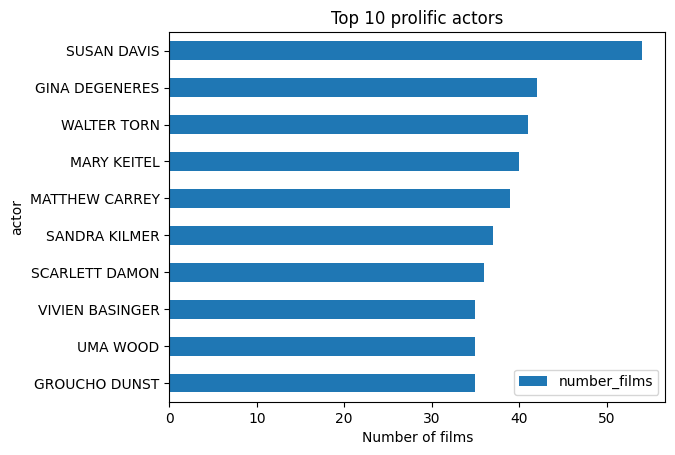

In [17]:
ax = actor_films.head(10).plot(
    kind="barh",
    x="actor",
    y="number_films",
    title="Top 10 prolific actors",
    xlabel="Number of films",
)

ax.invert_yaxis()